# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", ***you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.**

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


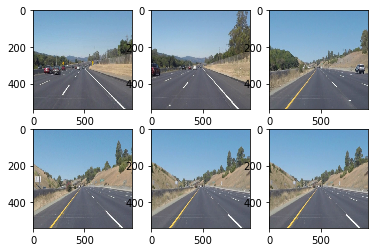

In [160]:
import os
#reading in an image
test_images_input = os.listdir("test_images/")
images=[]
for image in  os.listdir("test_images/"):
    images.append(mpimg.imread(os.path.join("test_images/",image)))
    
for image in images:
    print('This image is:', type(image), 'with dimensions:', image.shape)
#printing out some stats and plotting
# print('This image is:', type(image), 'with dimensions:', image.shape)
# plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# plot with various axes scales
plt.figure(1)

# linear       
plt.subplot(231)
plt.imshow(images[0],aspect='auto')

plt.subplot(232)
plt.imshow(images[1],aspect='auto')

plt.subplot(233)
plt.imshow(images[2],aspect='auto')

plt.subplot(234)
plt.imshow(images[3],aspect='auto')

plt.subplot(235)
plt.imshow(images[5],aspect='auto')

plt.subplot(236)
plt.imshow(images[5],aspect='auto')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [180]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)                        #defining a blank mask to start with
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]                 # i.e. will spit out count whether 3 or 4 depending on your image 
        ignore_mask_color = (255,) * channel_count   # 3 channel color mask
    else:
        ignore_mask_color = 255                      # 1 channel color mask
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)  # filling pixels inside the polygon defined by "vertices" with the fill color
    
    masked_image = cv2.bitwise_and(img, mask)        #returning the image only where mask pixels are nonzero
    return masked_image

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2): # callable from hough_lines()
    
    print('shape of lines vector',lines.shape)
    
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4). 
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    """
#     ==============================I am seperating VERTICAL, HORIZONAL, +VEslope, -VEslope line and added all slopes in that respective domain=============================
    only_verticle=[]   #  m=infinity , x2-x1=0 i.e parallel to y-axis
    only_horizontal=[] #  m=0 ,        y2-y1 =0 parallel to -axis
    only_positive=[]   #  m=+ve
    only_negative=[]   #  m=-ve
    postiveSlope=0
    negtiveSlope=0
    for line in lines:
        for x1,y1,x2,y2 in line:
                sum=0
                if (y2-y1)/(x2-x1) > 0:        #   +ve slope should be categorisied to left lane
                    only_positive.append(line)
                    postiveSlope+= ((y2-y1)/(x2-x1))  
                elif (y2-y1)/(x2-x1) < 0:      #   -ve slope to right lane
                    only_negative.append(line)
                    negtiveSlope+= abs((y2-y1)/(x2-x1))
                elif (x2-x1) == 0:
                    only_verticle.append(line)   # I have not found any verticle lines
                elif (y2-y1) ==0 :               # slope 0
                    if x2<500 or x1<500:         # the horizonatal line which are lesser than 500 should go with left lane.
                        only_positive.append(line)
                    else:                        # >500 should go to right lane
                        only_negative.append(line)
#     =========================================taken average of +ve slope, -ve slope , left_lanes , right_lanes ==================
    posSlope=round_int(postiveSlope/len(only_positive))
    negSlope=round_int(negtiveSlope/len(only_negative))
    
    only_positive_avg= np.average(only_positive, axis=0).astype(int)
    only_negative_avg= np.average(only_negative, axis=0).astype(int)
#     ========================================calculate Intercept with any single point on the average line===================  
    for x1,y1,x2,y2 in only_positive_avg:
        only_positive_avg_I= int(y1-(posSlope*x1))
    for x1,y1,x2,y2 in only_negative_avg:
        only_negative_avg_I= int(y1-(negSlope*x1))
#     ========================================calc minmum Y & X among all points in left_lanes & right lanes to get the bottom most point ===================
    min_left_y =  min_xy(only_positive)
    min_left_x =  calc_x(min_left_y,only_positive_avg_I, posSlope)  
    min_right_y= min_xy(only_negative)
    min_right_x = calc_x(min_right_y,only_negative_avg_I, negSlope)
#     ========================================calc max Y & X among all points in left_lanes & right lanes to get the farthest most point ===================
    max_left_y =  max_xy(only_positive)
    max_left_x = calc_x(max_left_y,only_positive_avg_I, posSlope)
    max_right_y= max_xy(only_negative)    
    max_right_x = calc_x(max_right_y,only_negative_avg_I, negSlope)
#     =========================================Finally, Prepared top & bottom coordinates to connect & draw a line ==================
    create_left_lane =[[min_left_x, min_left_y, max_left_x, max_left_y]]
    create_right_lane=[[min_right_x, min_right_y, max_right_x, max_right_y]]
    """
    This function draws `lines` with `color` and `thickness`. 
    Lines are drawn on the image inplace (mutates the image).If you want to make the lines semi-transparent, 
    think about combining this function with the weighted_img() function below
    """
    print('Final create_left_lane',create_left_lane, '\tcreate_right_lane',create_right_lane)
#     =========================================left_lane_lines drawn:  ==================                                         
    for x1,y1,x2,y2 in create_left_lane:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#     =========================================right_lane_lines drawn  ==================  
    for x1,y1,x2,y2 in create_right_lane:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
#     ========================================= Just a printing postion to verify results simultaneously==================        
    print('posSlope',posSlope,'\t only_positive_avg_I ',only_positive_avg_I,'\t min x',min_left_x,'& \t min y',min_left_y,'\t max x',max_left_x,'& \t max y',max_left_y)
    print('negSlope',negSlope,'\t only_negative_avg_I',only_negative_avg_I,'\t min x',min_right_x,'& \t min y',min_right_y,'\t max x',max_left_x,'& \t max y',max_left_y)
    print('*'*20)
    print('Final create_left_lane',create_left_lane, '\tcreate_right_lane',create_right_lane)
    print('*'*20)
    print('only_positive_avg',only_positive_avg,'\tonly_negative_avg',only_negative_avg)
    print('*'*20)
    print('Shape of only_positive lines',len(only_positive),'\t first coordinates ',only_positive[0][0])
    print('\nshape of only_negative lines', len(only_negative),'\t first coordinates ',only_negative[0][0])
    print('\nshape of only_verticle lines',len(only_verticle),'\t first coordinates ',only_verticle)
    print('\nshape of only_horizontal lines',len(only_horizontal),'\t first coordinates ',only_horizontal)
    print('*'*100)
#     ========================================= Just a printing postion to verify results simultaneously==================         

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)    # by using the dimensions of original image, creating a complete Blacked out copy of it.

    draw_lines(line_img, lines)                                             # calling the draw_lines function, which will draws lines on the hough returned coordinates in fully Blacked-out Image.

    return line_img                                                         # this image has connected(line drawn) coordinates in complete Black-out image. 

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Added Helper functions to support draw_lines() .

In [182]:
'''
Handle floating "inf" while calculating anything related to negative slopes.
'''
def round_int(x):
    if x == float("inf"):
        return float('960') # something big
    elif x== float("-inf"):
        return float('-960')
    return int(x)
'''
I catched the corresponding min & max x for min & max y from the function max_xy and min_xy, but I was advised by a four mentor to 
calculate corresponding x for y's so I did that here.
Question: I still did not get clarity on Why I have to calculate x when I can retrive exact x_min for y_min as well as maxs.?????????
'''    
def calc_x(y,intercept, slope):
    x= round_int((y-intercept)/slope)
    return int(x)
'''
This function simply calculates the min of all y's (y1 & y2) and catches their corresponding x's., But due to the issue mentioned above
I calculted x's for y's with the help of calc_x() function.
'''
def min_xy(lane_lines):
    for line in lane_lines:
        temp=960
        temp1=960
        for x1,y1,x2,y2 in line:
            if temp>=y1:
                temp=y1
                if temp==y1:
                    temp_x1=x1
            if temp1>=y2:
                temp1=y2
                if temp1==y2:
                    temp1_x2=x2
    if temp<temp1:
        min_y=temp
        min_x=temp_x1
    else:
        min_y=temp1
        min_x=temp1_x2
    return min_y 
'''
This function simply calculates the max of all y's (y1 & y2) and catches their corresponding x's. But due to the issue mentioned above
I calculted x's for y's with the help of calc_x() function.
'''
def max_xy(lane_lines):
    for line in lane_lines:
        temp=0
        temp1=0
        for x1,y1,x2,y2 in line:
            if temp<=y1:
                temp=y1
                if temp==y1:
                    temp_x1=x1
            if temp1<=y2:
                temp1=y2
                if temp1==y2:
                    temp1_x2=x2
    if temp>temp1:
        max_y=temp
        max_x=temp_x1
    else:
        max_y=temp1
        max_x=temp1_x2    
    return max_y 

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [183]:
import os,re
INPUT_PATH  = 'test_images/'
OUTPUT_PATH = 'test_images_output/'
def read_save_images(input_dir=INPUT_PATH, output_dir=OUTPUT_PATH):           # Automate the data fetching process.
    
    test_images_input = os.listdir(input_dir)                                 #     read input images into a list
    
    if not os.path.isdir(output_dir):                                         #     output directory doesn't exist then create one
        os.makedirs(output_dir)
    
    for text_images in test_images_input:
        image = mpimg.imread( os.path.join(input_dir,text_images))            #         read each image into program
        pipeLine_output_image = laneFindingPipeLine(image)                    #         send this image to your pipeline to process it
        modify_name = re.sub(r'\.jpg$', '', text_images)
        mpimg.imsave( os.path.join(output_dir,modify_name+'_output.jpg'),pipeLine_output_image) #         put the final image into the directory
    return  

In [184]:
'''
simply calling the pipeline here
'''
read_save_images()

shape of lines vector (108, 1, 4)
Final create_left_lane [[960, 525, 960, 538]] 	create_right_lane [[419, 388, 419, 391]]
posSlope 0 	 only_positive_avg_I  328 	 min x 960 & 	 min y 525 	 max x 960 & 	 max y 538
negSlope 960.0 	 only_negative_avg_I -401929 	 min x 419 & 	 min y 388 	 max x 960 & 	 max y 538
********************
Final create_left_lane [[960, 525, 960, 538]] 	create_right_lane [[419, 388, 419, 391]]
********************
only_positive_avg [[435 328 476 344]] 	only_negative_avg [[419 311 437 306]]
********************
Shape of only_positive lines 40 	 first coordinates  [511 324 722 441]

shape of only_negative lines 68 	 first coordinates  [414 294 439 292]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in int_scalars
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in int_scalars
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in int_scalars
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


 (87, 1, 4)
Final create_left_lane [[960, 334, 960, 336]] 	create_right_lane [[415, 377, 415, 380]]
posSlope 0 	 only_positive_avg_I  318 	 min x 960 & 	 min y 334 	 max x 960 & 	 max y 336
negSlope 960.0 	 only_negative_avg_I -398094 	 min x 415 & 	 min y 377 	 max x 960 & 	 max y 336
********************
Final create_left_lane [[960, 334, 960, 336]] 	create_right_lane [[415, 377, 415, 380]]
********************
only_positive_avg [[417 318 471 342]] 	only_negative_avg [[415 306 433 300]]
********************
Shape of only_positive lines 35 	 first coordinates  [495 314 853 538]

shape of only_negative lines 52 	 first coordinates  [580 290 605 285]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (111, 1, 4)
Final create_left_lane [[960, 393, 960, 413]] 	create_right_lane [[960, 482, 960, 498]]
posSl

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in int_scalars


shape of lines vector (136, 1, 4)
Final create_left_lane [[960, 486, 960, 493]] 	create_right_lane [[960, 359, 960, 372]]
posSlope 0 	 only_positive_avg_I  343 	 min x 960 & 	 min y 486 	 max x 960 & 	 max y 493
negSlope 0 	 only_negative_avg_I 328 	 min x 960 & 	 min y 359 	 max x 960 & 	 max y 493
********************
Final create_left_lane [[960, 486, 960, 493]] 	create_right_lane [[960, 359, 960, 372]]
********************
only_positive_avg [[526 343 544 348]] 	only_negative_avg [[473 328 497 320]]
********************
Shape of only_positive lines 65 	 first coordinates  [127 303 144 303]

shape of only_negative lines 71 	 first coordinates  [138 538 365 385]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (138, 1, 4)
Final create_left_lane [[960, 484, 960, 484]] 	create_right_lane [[960, 468, 96

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [97]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def laneFindingPipeLine(img):
#     plt.figure(2)
#     print('Original_image shape',img.shape )
#     plt.subplot(331)
#     plt.imshow(img,aspect='auto')
    '''
     to apply canny algorithm, convert color image to gray i,e a single channel image
     gray image helps us to clearly identify, DARK/ BRIGHT/ GRAY(in between) pixels in the image. 
     Also, rapid changing in the brightess, we will be able to find edges/dots
    '''
    gray_image = grayscale(img)
#     print('gray_image shape',gray_image.shape )
#     plt.subplot(332)
#     plt.imshow(gray_image,aspect='auto')
    
    '''
    filter-out noise and spurious gradients by averaging  with gaussian filter, keeping Kernel_size = 5, **always select a odd size number.
    '''
    kernel_size=5
    blur_gray = gaussian_blur(gray_image, kernel_size)
#     print('blur_gray shape',blur_gray.shape )
#     plt.subplot(333)
#     plt.imshow(blur_gray,aspect='auto')
    '''
    now, we can apply canny algorithm, that
    apply its gaussian filter--> finds the gradient strength & direction(you get thick edges)-->apply non-max. suppression(get thin/candidate edges)-->Hysteresis with the help of thresholds specifies in the arguments
    '''
    low_threshold  = 70
    high_threshold = 140
    canny_edges = canny(blur_gray, low_threshold, high_threshold)
#     print('canny_edges shape',canny_edges.shape )
#     plt.subplot(334)
#     plt.imshow(canny_edges,aspect='auto')
    '''
    Work is not done YET..!!
    We just have dotted-lane-lines detected.
    So, we connect them..? How we know which dot to connect with which other dot, & how many dots to connect? ...TRICKY SITUATION...!!!
    Awesome Manipulation by hough, We have dots in our image space, which equivalent to a line for each dot in Hough space. And, collinear points in image space
    is equivalent to respective lines passing through common intersection point/pixel in Hough space. Also, in Hough space we have grids cells, which helps to 
    catch all the edges/dots in images space which are not collinear but very much near to collinear points by adjusting THRESHOLD parameter in below function.
    The more count we get of lines passing through a grid pixel in hough space, the more we get collinear/near-collinear edges/dots in out image space.
    This way we will be able to clear identify the sequence of coordinates of all near-collinear points in the canny_edge_detected_masked_image ....AMAZING..!!
    
    Now, you have the coordinates, Connect them with a line, by calling custom draw_lines()
    '''
    rho = 1
    theta = np.pi/180
    threshold = 12
    min_line_len = 10
    max_line_gap = 2
    line_img = hough_lines(canny_edges, rho, theta, threshold, min_line_len, max_line_gap) # --> will call draw lines & you get a Blacked-out image with connected Hough returned coordinates.
#     print('line_img shape',line_img.shape )
#     plt.subplot(335)
#     plt.imshow(line_img,aspect='auto')
    '''
    Now, you have a edge-detected image : which has edges all over the image based on you detection criterion. This doesn't solve our purpose. 
    We need to narrow-down our area of visibility to not to let our algorithm confuse.
    Create a region of interest, a polygon around the specific lane line.
    This function takes the coordinates of the polygon and draws a polygon in the image,
    then fill with a RED color <-- this becomes your mask.(a specific area to look on.)
    then it performs bitwise AND with canny_edge_detected_image(which is full of edges everywhere) & mask_image(just a plane RED POLYGON SHAPE in the image)--> gives a canny_edge_detected_masked_image
    So, now you have clear RED-HIGHLIGHTNED canny- edges....BEAUTIFULL..!!! :)
    
    Note: Create a mask is independent of any operatio, Moreover, you want to create Mask on the line_image that's why you have to 
          do a bit-wise AND to get only the masked-line Image. Do not repeat it again...!!!!
    '''
    vertices = np.array([[(0,539),(425, 340), (510, 320), (959,539)]], dtype=np.int32)
    masked_image = region_of_interest(img, vertices)
#     print('masked_image shape',masked_image.shape )
#     plt.subplot(336)
#     plt.imshow(masked_image,aspect='auto')
    '''
    have to mask the line_image so that we can get the specific area in the image to look on
    '''
    masked_line_img = cv2.bitwise_and(masked_image, line_img)
#     print('masked_line_img shape',masked_line_img.shape )
#     plt.subplot(337)
#     plt.imshow(masked_line_img,aspect='auto')
    '''
    now we have 1. a image with hough generated connected coordinates
                2. a image with masked-region(polygon) with canny detected edges. 
    this function will give weights to each pixel & glue them together. 
    Remember, before gluing, the dimension shoudld be same, else it pops out errors.
    img==1 & initial_img==2(original image)
    '''
    output = weighted_img(masked_line_img, img, α=0.8, β=1., λ=0.)
#     print('output shape',output.shape )
#     plt.subplot(338)
#     plt.imshow(output,aspect='auto')
    return output


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [185]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output shape (540, 960, 4)


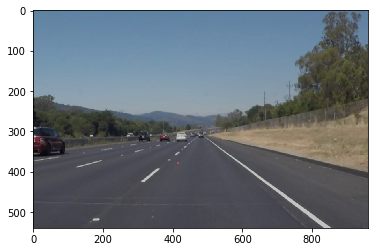

In [186]:
if not os.path.isdir('test_videos_output/'):         #     output directory doesn't exist then create one
        os.makedirs('test_videos_output/')
    
image = mpimg.imread(os.path.join('test_images_output/solidWhiteRight_output.jpg'))
print('output shape',image.shape )
plt.imshow(image,aspect='auto') 
plt.show()
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)  
    result = laneFindingPipeLine(image)   
    return result                    

Let's try the one with the solid white lane on the right first ...

In [189]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

shape of lines vector (205, 1, 4)
Final create_left_lane [[647, 320, 647, 327]] 	create_right_lane [[553, 445, 553, 454]]
posSlope 960.0 	 only_positive_avg_I  -620833 	 min x 647 & 	 min y 320 	 max x 647 & 	 max y 327
negSlope 960.0 	 only_negative_avg_I -530666 	 min x 553 & 	 min y 445 	 max x 647 & 	 max y 327
********************
Final create_left_lane [[647, 320, 647, 327]] 	create_right_lane [[553, 445, 553, 454]]
********************
only_positive_avg [[647 287 673 298]] 	only_negative_avg [[553 214 573 208]]
********************
Shape of only_positive lines 93 	 first coordinates  [686 428 869 538]

shape of only_negative lines 112 	 first coordinates  [842  45 854  39]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video tes

  3%|▎         | 6/222 [00:00<00:03, 54.04it/s]

shape of lines vector (205, 1, 4)
Final create_left_lane [[647, 320, 647, 327]] 	create_right_lane [[553, 445, 553, 454]]
posSlope 960.0 	 only_positive_avg_I  -620833 	 min x 647 & 	 min y 320 	 max x 647 & 	 max y 327
negSlope 960.0 	 only_negative_avg_I -530666 	 min x 553 & 	 min y 445 	 max x 647 & 	 max y 327
********************
Final create_left_lane [[647, 320, 647, 327]] 	create_right_lane [[553, 445, 553, 454]]
********************
only_positive_avg [[647 287 673 298]] 	only_negative_avg [[553 214 573 208]]
********************
Shape of only_positive lines 93 	 first coordinates  [686 428 869 538]

shape of only_negative lines 112 	 first coordinates  [842  45 854  39]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (185, 1, 4)
Final create_left_lane [[646, 437, 646, 450]] 	create_right_la

  6%|▋         | 14/222 [00:00<00:04, 44.05it/s]



shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (107, 1, 4)
Final create_left_lane [[560, 492, 560, 500]] 	create_right_lane [[419, 328, 419, 337]]
posSlope 960.0 	 only_positive_avg_I  -537277 	 min x 560 & 	 min y 492 	 max x 560 & 	 max y 500
negSlope 960.0 	 only_negative_avg_I -401930 	 min x 419 & 	 min y 328 	 max x 560 & 	 max y 500
********************
Final create_left_lane [[560, 492, 560, 500]] 	create_right_lane [[419, 328, 419, 337]]
********************
only_positive_avg [[560 323 596 340]] 	only_negative_avg [[419 310 437 305]]
********************
Shape of only_positive lines 44 	 first coordinates  [579 369 849 538]

shape of only_negative lines 63 	 first coordinates  [679 267 700 263]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 firs

 10%|█         | 23/222 [00:00<00:04, 43.64it/s]

	 only_positive_avg_I  -404812 	 min x 422 & 	 min y 530 	 max x 422 & 	 max y 539
negSlope 0 	 only_negative_avg_I 295 	 min x 960 & 	 min y 380 	 max x 422 & 	 max y 539
********************
Final create_left_lane [[422, 530, 422, 539]] 	create_right_lane [[960, 380, 960, 388]]
********************
only_positive_avg [[422 308 472 330]] 	only_negative_avg [[396 295 412 290]]
********************
Shape of only_positive lines 37 	 first coordinates  [495 314 708 453]

shape of only_negative lines 51 	 first coordinates  [ 89 358 113 355]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (99, 1, 4)
Final create_left_lane [[434, 395, 434, 400]] 	create_right_lane [[960, 382, 960, 389]]
posSlope 960.0 	 only_positive_avg_I  -416328 	 min x 434 & 	 min y 395 	 max x 434 & 	 max y 400
negSlope 0 	 only_negat

 14%|█▍        | 31/222 [00:00<00:04, 41.37it/s]

[]
****************************************************************************************************
shape of lines vector (107, 1, 4)
Final create_left_lane [[960, 380, 960, 399]] 	create_right_lane [[457, 375, 457, 381]]
posSlope 0 	 only_positive_avg_I  324 	 min x 960 & 	 min y 380 	 max x 960 & 	 max y 399
negSlope 960.0 	 only_negative_avg_I -438411 	 min x 457 & 	 min y 375 	 max x 960 & 	 max y 399
********************
Final create_left_lane [[960, 380, 960, 399]] 	create_right_lane [[457, 375, 457, 381]]
********************
only_positive_avg [[433 324 466 338]] 	only_negative_avg [[457 309 475 301]]
********************
Shape of only_positive lines 49 	 first coordinates  [516 326 855 538]

shape of only_negative lines 58 	 first coordinates  [724 260 736 258]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
s

 16%|█▌        | 35/222 [00:00<00:04, 40.43it/s]

35 	 first coordinates  [634 335 841 375]

shape of only_negative lines 55 	 first coordinates  [ 33 351  46 350]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (101, 1, 4)
Final create_left_lane [[421, 242, 421, 252]] 	create_right_lane [[359, 400, 359, 403]]
posSlope 960.0 	 only_positive_avg_I  -404797 	 min x 421 & 	 min y 242 	 max x 421 & 	 max y 252
negSlope 960.0 	 only_negative_avg_I -344326 	 min x 359 & 	 min y 400 	 max x 421 & 	 max y 252
********************
Final create_left_lane [[421, 242, 421, 252]] 	create_right_lane [[359, 400, 359, 403]]
********************
only_positive_avg [[422 323 455 336]] 	only_negative_avg [[359 314 379 307]]
********************
Shape of only_positive lines 50 	 first coordinates  [648 339 717 352]

shape of only_negative lines 51 	 first coordinates  [

 18%|█▊        | 40/222 [00:00<00:04, 41.79it/s]

shape of lines vector (112, 1, 4)
Final create_left_lane [[456, 513, 456, 520]] 	create_right_lane [[418, 419, 418, 427]]
posSlope 960.0 	 only_positive_avg_I  -437448 	 min x 456 & 	 min y 513 	 max x 456 & 	 max y 520
negSlope 960.0 	 only_negative_avg_I -400970 	 min x 418 & 	 min y 419 	 max x 456 & 	 max y 520
********************
Final create_left_lane [[456, 513, 456, 520]] 	create_right_lane [[418, 419, 418, 427]]
********************
only_positive_avg [[456 312 491 328]] 	only_negative_avg [[418 310 438 302]]
********************
Shape of only_positive lines 51 	 first coordinates  [624 403 775 501]

shape of only_negative lines 61 	 first coordinates  [ 79 355 113 352]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (114, 1, 4)
Final create_left_lane [[960, 519, 960, 538]] 	create_right_lan

 23%|██▎       | 50/222 [00:01<00:04, 40.32it/s]

 [[394 312 410 307]]
********************
Shape of only_positive lines 48 	 first coordinates  [515 326 799 517]

shape of only_negative lines 58 	 first coordinates  [ 64 358  77 356]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (117, 1, 4)
Final create_left_lane [[501, 467, 501, 486]] 	create_right_lane [[405, 514, 405, 515]]
posSlope 960.0 	 only_positive_avg_I  -480639 	 min x 501 & 	 min y 467 	 max x 501 & 	 max y 486
negSlope 960.0 	 only_negative_avg_I -388489 	 min x 405 & 	 min y 514 	 max x 501 & 	 max y 486
********************
Final create_left_lane [[501, 467, 501, 486]] 	create_right_lane [[405, 514, 405, 515]]
********************
only_positive_avg [[501 321 532 336]] 	only_negative_avg [[405 311 424 305]]
********************
Shape of only_positive lines 57 	 first coordinates  [4

 27%|██▋       | 60/222 [00:01<00:04, 40.46it/s]

	create_right_lane [[466, 162, 466, 173]]
posSlope 960.0 	 only_positive_avg_I  -421139 	 min x 438 & 	 min y 239 	 max x 438 & 	 max y 250
negSlope 960.0 	 only_negative_avg_I -448023 	 min x 466 & 	 min y 162 	 max x 438 & 	 max y 250
********************
Final create_left_lane [[438, 239, 438, 250]] 	create_right_lane [[466, 162, 466, 173]]
********************
only_positive_avg [[439 301 490 326]] 	only_negative_avg [[467 297 482 291]]
********************
Shape of only_positive lines 39 	 first coordinates  [559 356 831 539]

shape of only_negative lines 61 	 first coordinates  [186 312 205 311]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (108, 1, 4)
Final create_left_lane [[471, 203, 471, 213]] 	create_right_lane [[479, 391, 479, 399]]
posSlope 960.0 	 only_positive_avg_I  -452822 	 min x 4

 32%|███▏      | 70/222 [00:01<00:03, 38.24it/s]

 69 	 first coordinates  [842 240 864 236]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (118, 1, 4)
Final create_left_lane [[444, 459, 444, 467]] 	create_right_lane [[416, 528, 416, 535]]
posSlope 960.0 	 only_positive_avg_I  -425935 	 min x 444 & 	 min y 459 	 max x 444 & 	 max y 467
negSlope 960.0 	 only_negative_avg_I -399046 	 min x 416 & 	 min y 528 	 max x 444 & 	 max y 467
********************
Final create_left_lane [[444, 459, 444, 467]] 	create_right_lane [[416, 528, 416, 535]]
********************
only_positive_avg [[444 305 480 323]] 	only_negative_avg [[416 314 432 307]]
********************
Shape of only_positive lines 48 	 first coordinates  [552 356 822 538]

shape of only_negative lines 70 	 first coordinates  [112 356 150 350]

shape of only_verticle lines 0 	 first coordinates  [

 35%|███▌      | 78/222 [00:01<00:03, 38.68it/s]


********************
Final create_left_lane [[464, 447, 464, 463]] 	create_right_lane [[403, 398, 403, 401]]
********************
only_positive_avg [[464 308 500 325]] 	only_negative_avg [[403 323 422 315]]
********************
Shape of only_positive lines 54 	 first coordinates  [492 311 516 327]

shape of only_negative lines 64 	 first coordinates  [867 236 881 234]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (114, 1, 4)
Final create_left_lane [[467, 445, 467, 463]] 	create_right_lane [[409, 527, 409, 538]]
posSlope 960.0 	 only_positive_avg_I  -447999 	 min x 467 & 	 min y 445 	 max x 467 & 	 max y 463
negSlope 960.0 	 only_negative_avg_I -392323 	 min x 409 & 	 min y 527 	 max x 467 & 	 max y 463
********************
Final create_left_lane [[467, 445, 467, 463]] 	create_right_lane [[409, 527

 40%|███▉      | 88/222 [00:02<00:03, 40.65it/s]

[703 265 719 262]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (123, 1, 4)
Final create_left_lane [[465, 337, 465, 348]] 	create_right_lane [[456, 446, 456, 466]]
posSlope 960.0 	 only_positive_avg_I  -446089 	 min x 465 & 	 min y 337 	 max x 465 & 	 max y 348
negSlope 960.0 	 only_negative_avg_I -437446 	 min x 456 & 	 min y 446 	 max x 465 & 	 max y 348
********************
Final create_left_lane [[465, 337, 465, 348]] 	create_right_lane [[456, 446, 456, 466]]
********************
only_positive_avg [[465 311 502 330]] 	only_negative_avg [[456 314 475 306]]
********************
Shape of only_positive lines 54 	 first coordinates  [490 313 513 329]

shape of only_negative lines 69 	 first coordinates  [537 301 547 301]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizont

 44%|████▍     | 98/222 [00:02<00:03, 39.94it/s]


****************************************************************************************************
shape of lines vector (127, 1, 4)
Final create_left_lane [[518, 430, 518, 434]] 	create_right_lane [[464, 220, 464, 242]]
posSlope 960.0 	 only_positive_avg_I  -496953 	 min x 518 & 	 min y 430 	 max x 518 & 	 max y 434
negSlope 960.0 	 only_negative_avg_I -446098 	 min x 464 & 	 min y 220 	 max x 518 & 	 max y 434
********************
Final create_left_lane [[518, 430, 518, 434]] 	create_right_lane [[464, 220, 464, 242]]
********************
only_positive_avg [[518 327 556 346]] 	only_negative_avg [[465 302 480 295]]
********************
Shape of only_positive lines 52 	 first coordinates  [545 348 775 503]

shape of only_negative lines 75 	 first coordinates  [769 253 788 249]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
************************************************************************************************

 48%|████▊     | 107/222 [00:02<00:03, 36.82it/s]



shape of only_negative lines 64 	 first coordinates  [188 316 213 314]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (114, 1, 4)
Final create_left_lane [[435, 527, 435, 536]] 	create_right_lane [[447, 159, 447, 177]]
posSlope 960.0 	 only_positive_avg_I  -417298 	 min x 435 & 	 min y 527 	 max x 435 & 	 max y 536
negSlope 960.0 	 only_negative_avg_I -429768 	 min x 447 & 	 min y 159 	 max x 435 & 	 max y 536
********************
Final create_left_lane [[435, 527, 435, 536]] 	create_right_lane [[447, 159, 447, 177]]
********************
only_positive_avg [[435 302 472 319]] 	only_negative_avg [[448 312 463 305]]
********************
Shape of only_positive lines 45 	 first coordinates  [222 245 245 249]

shape of only_negative lines 69 	 first coordinates  [450 323 460 321]

shape of only_verticle 

 52%|█████▏    | 115/222 [00:02<00:02, 37.84it/s]

 & 	 min y 517 	 max x 446 & 	 max y 538
negSlope 960.0 	 only_negative_avg_I -331819 	 min x 346 & 	 min y 493 	 max x 446 & 	 max y 538
********************
Final create_left_lane [[446, 517, 446, 538]] 	create_right_lane [[346, 493, 346, 500]]
********************
only_positive_avg [[446 302 484 322]] 	only_negative_avg [[346 341 366 332]]
********************
Shape of only_positive lines 50 	 first coordinates  [609 392 817 538]

shape of only_negative lines 77 	 first coordinates  [143 355 162 352]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (112, 1, 4)
Final create_left_lane [[408, 412, 408, 441]] 	create_right_lane [[392, 480, 392, 489]]
posSlope 960.0 	 only_positive_avg_I  -391385 	 min x 408 & 	 min y 412 	 max x 408 & 	 max y 441
negSlope 960.0 	 only_negative_avg_I -375993 	 min x 392

 56%|█████▌    | 124/222 [00:03<00:02, 39.02it/s]

 -97 	 min x 547 & 	 min y 450 	 max x 581 & 	 max y 484
negSlope 960.0 	 only_negative_avg_I -424008 	 min x 442 & 	 min y 427 	 max x 581 & 	 max y 484
********************
Final create_left_lane [[547, 450, 581, 484]] 	create_right_lane [[442, 427, 442, 444]]
********************
only_positive_avg [[398 301 433 319]] 	only_negative_avg [[442 312 457 305]]
********************
Shape of only_positive lines 55 	 first coordinates  [499 313 657 415]

shape of only_negative lines 85 	 first coordinates  [435 293 445 292]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (132, 1, 4)
Final create_left_lane [[398, 517, 398, 536]] 	create_right_lane [[450, 431, 450, 437]]
posSlope 960.0 	 only_positive_avg_I  -381772 	 min x 398 & 	 min y 517 	 max x 398 & 	 max y 536
negSlope 960.0 	 only_negative_avg_I -43

 61%|██████▏   | 136/222 [00:03<00:02, 37.78it/s]

[[466, 486, 466, 493]] 	create_right_lane [[414, 301, 415, 302]]
********************
only_positive_avg [[466 309 497 325]] 	only_negative_avg [[415 302 431 298]]
********************
Shape of only_positive lines 61 	 first coordinates  [499 314 835 524]

shape of only_negative lines 63 	 first coordinates  [399 301 439 297]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (118, 1, 4)
Final create_left_lane [[415, 58, 415, 69]] 	create_right_lane [[411, 390, 411, 400]]
posSlope 960.0 	 only_positive_avg_I  -399092 	 min x 415 & 	 min y 58 	 max x 415 & 	 max y 69
negSlope 960.0 	 only_negative_avg_I -394255 	 min x 411 & 	 min y 390 	 max x 415 & 	 max y 69
********************
Final create_left_lane [[415, 58, 415, 69]] 	create_right_lane [[411, 390, 411, 400]]
********************
only_positive_avg 

 63%|██████▎   | 140/222 [00:03<00:02, 37.98it/s]

shape of lines vector (94, 1, 4)
Final create_left_lane [[429, 528, 429, 538]] 	create_right_lane [[430, 518, 430, 529]]
posSlope 960.0 	 only_positive_avg_I  -411514 	 min x 429 & 	 min y 528 	 max x 429 & 	 max y 538
negSlope 960.0 	 only_negative_avg_I -412473 	 min x 430 & 	 min y 518 	 max x 429 & 	 max y 538
********************
Final create_left_lane [[429, 528, 429, 538]] 	create_right_lane [[430, 518, 430, 529]]
********************
only_positive_avg [[429 326 475 347]] 	only_negative_avg [[430 327 447 322]]
********************
Shape of only_positive lines 39 	 first coordinates  [500 312 617 385]

shape of only_negative lines 55 	 first coordinates  [549 280 565 279]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (100, 1, 4)
Final create_left_lane [[455, 457, 455, 464]] 	create_right_lane

 67%|██████▋   | 149/222 [00:03<00:01, 38.57it/s]

 -400947 	 min x 418 & 	 min y 404 	 max x 402 & 	 max y 538
********************
Final create_left_lane [[402, 506, 402, 538]] 	create_right_lane [[418, 404, 418, 407]]
********************
only_positive_avg [[402 312 439 328]] 	only_negative_avg [[418 333 438 325]]
********************
Shape of only_positive lines 54 	 first coordinates  [583 327 613 332]

shape of only_negative lines 66 	 first coordinates  [425 303 436 302]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (123, 1, 4)
Final create_left_lane [[435, 507, 435, 519]] 	create_right_lane [[353, 407, 353, 410]]
posSlope 960.0 	 only_positive_avg_I  -417287 	 min x 435 & 	 min y 507 	 max x 435 & 	 max y 519
negSlope 960.0 	 only_negative_avg_I -338554 	 min x 353 & 	 min y 407 	 max x 435 & 	 max y 519
********************
Final create_le

 72%|███████▏  | 159/222 [00:04<00:01, 38.46it/s]

 	only_negative_avg [[380 317 398 313]]
********************
Shape of only_positive lines 55 	 first coordinates  [557 346 811 504]

shape of only_negative lines 70 	 first coordinates  [842 283 878 282]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (120, 1, 4)
Final create_left_lane [[466, 446, 466, 462]] 	create_right_lane [[418, 355, 418, 360]]
posSlope 960.0 	 only_positive_avg_I  -447033 	 min x 466 & 	 min y 446 	 max x 466 & 	 max y 462
negSlope 960.0 	 only_negative_avg_I -400967 	 min x 418 & 	 min y 355 	 max x 466 & 	 max y 462
********************
Final create_left_lane [[466, 446, 466, 462]] 	create_right_lane [[418, 355, 418, 360]]
********************
only_positive_avg [[466 327 498 341]] 	only_negative_avg [[418 313 438 308]]
********************
Shape of only_positive lines 55 	 fi

 75%|███████▌  | 167/222 [00:04<00:01, 36.60it/s]

 	 first coordinates  []
****************************************************************************************************
shape of lines vector (145, 1, 4)
Final create_left_lane [[960, 454, 960, 459]] 	create_right_lane [[-960, 282, -960, 282]]
posSlope 0 	 only_positive_avg_I  349 	 min x 960 & 	 min y 454 	 max x 960 & 	 max y 459
negSlope 0 	 only_negative_avg_I 298 	 min x -960 & 	 min y 282 	 max x 960 & 	 max y 459
********************
Final create_left_lane [[960, 454, 960, 459]] 	create_right_lane [[-960, 282, -960, 282]]
********************
only_positive_avg [[400 349 430 359]] 	only_negative_avg [[458 298 472 295]]
********************
Shape of only_positive lines 67 	 first coordinates  [497 312 723 443]

shape of only_negative lines 78 	 first coordinates  [395 320 411 319]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
***********************************************************************************

 79%|███████▉  | 175/222 [00:04<00:01, 36.09it/s]

 []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (138, 1, 4)
Final create_left_lane [[960, 442, 960, 490]] 	create_right_lane [[414, 415, 414, 418]]
posSlope 0 	 only_positive_avg_I  326 	 min x 960 & 	 min y 442 	 max x 960 & 	 max y 490
negSlope 960.0 	 only_negative_avg_I -397109 	 min x 414 & 	 min y 415 	 max x 960 & 	 max y 490
********************
Final create_left_lane [[960, 442, 960, 490]] 	create_right_lane [[414, 415, 414, 418]]
********************
only_positive_avg [[340 326 372 337]] 	only_negative_avg [[414 331 433 325]]
********************
Shape of only_positive lines 59 	 first coordinates  [539 339 885 539]

shape of only_negative lines 79 	 first coordinates  [422 308 445 306]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
*******************************************

 82%|████████▏ | 183/222 [00:04<00:01, 33.49it/s]

0 	 only_negative_avg_I 311 	 min x 960 & 	 min y 349 	 max x 960 & 	 max y 485
********************
Final create_left_lane [[960, 463, 960, 485]] 	create_right_lane [[960, 349, 960, 350]]
********************
only_positive_avg [[379 333 412 345]] 	only_negative_avg [[449 311 466 308]]
********************
Shape of only_positive lines 56 	 first coordinates  [565 354 884 538]

shape of only_negative lines 63 	 first coordinates  [ 93 356 106 355]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (141, 1, 4)
Final create_left_lane [[960, 419, 960, 432]] 	create_right_lane [[960, 369, 960, 371]]
posSlope 0 	 only_positive_avg_I  332 	 min x 960 & 	 min y 419 	 max x 960 & 	 max y 432
negSlope 0 	 only_negative_avg_I 310 	 min x 960 & 	 min y 369 	 max x 960 & 	 max y 432
********************
Final create

 86%|████████▌ | 191/222 [00:04<00:00, 35.31it/s]

 [615 384 797 497]

shape of only_negative lines 74 	 first coordinates  [690 299 712 299]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (121, 1, 4)
Final create_left_lane [[960, 460, 960, 474]] 	create_right_lane [[960, 361, 960, 364]]
posSlope 0 	 only_positive_avg_I  348 	 min x 960 & 	 min y 460 	 max x 960 & 	 max y 474
negSlope 0 	 only_negative_avg_I 310 	 min x 960 & 	 min y 361 	 max x 960 & 	 max y 474
********************
Final create_left_lane [[960, 460, 960, 474]] 	create_right_lane [[960, 361, 960, 364]]
********************
only_positive_avg [[474 348 511 363]] 	only_negative_avg [[426 310 442 307]]
********************
Shape of only_positive lines 50 	 first coordinates  [604 374 668 410]

shape of only_negative lines 71 	 first coordinates  [831 296 864 296]

shape of only_verticl

 92%|█████████▏| 204/222 [00:05<00:00, 37.54it/s]

	 first coordinates  [211 311 222 310]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (116, 1, 4)
Final create_left_lane [[436, 462, 436, 474]] 	create_right_lane [[-960, 258, -960, 259]]
posSlope 960.0 	 only_positive_avg_I  -418242 	 min x 436 & 	 min y 462 	 max x 436 & 	 max y 474
negSlope 0 	 only_negative_avg_I 313 	 min x -960 & 	 min y 258 	 max x 436 & 	 max y 474
********************
Final create_left_lane [[436, 462, 436, 474]] 	create_right_lane [[-960, 258, -960, 259]]
********************
only_positive_avg [[436 318 471 331]] 	only_negative_avg [[494 313 510 309]]
********************
Shape of only_positive lines 55 	 first coordinates  [627 393 797 495]

shape of only_negative lines 61 	 first coordinates  [942 298 954 298]

shape of only_verticle lines 0 	 first coordinates  []

shap

 94%|█████████▎| 208/222 [00:05<00:00, 37.65it/s]

shape of lines vector (132, 1, 4)
Final create_left_lane [[409, 493, 409, 531]] 	create_right_lane [[960, 475, 960, 483]]
posSlope 960.0 	 only_positive_avg_I  -392319 	 min x 409 & 	 min y 493 	 max x 409 & 	 max y 531
negSlope 0 	 only_negative_avg_I 302 	 min x 960 & 	 min y 475 	 max x 409 & 	 max y 531
********************
Final create_left_lane [[409, 493, 409, 531]] 	create_right_lane [[960, 475, 960, 483]]
********************
only_positive_avg [[409 321 442 333]] 	only_negative_avg [[498 302 516 297]]
********************
Shape of only_positive lines 57 	 first coordinates  [752 355 875 378]

shape of only_negative lines 75 	 first coordinates  [796 296 822 296]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (128, 1, 4)
Final create_left_lane [[433, 269, 433, 280]] 	create_right_lane [[960,

 99%|█████████▉| 220/222 [00:05<00:00, 37.56it/s]

 [785 295 819 295]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
shape of lines vector (135, 1, 4)
Final create_left_lane [[405, 509, 405, 514]] 	create_right_lane [[443, 495, 443, 496]]
posSlope 960.0 	 only_positive_avg_I  -388477 	 min x 405 & 	 min y 509 	 max x 405 & 	 max y 514
negSlope 960.0 	 only_negative_avg_I -424980 	 min x 443 & 	 min y 495 	 max x 405 & 	 max y 514
********************
Final create_left_lane [[405, 509, 405, 514]] 	create_right_lane [[443, 495, 443, 496]]
********************
only_positive_avg [[405 323 435 334]] 	only_negative_avg [[443 300 459 297]]
********************
Shape of only_positive lines 61 	 first coordinates  [684 425 873 534]

shape of only_negative lines 74 	 first coordinates  [447 287 467 285]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizon

100%|█████████▉| 221/222 [00:05<00:00, 38.43it/s]


shape of lines vector (130, 1, 4)
Final create_left_lane [[453, 491, 453, 496]] 	create_right_lane [[377, 357, 377, 359]]
posSlope 960.0 	 only_positive_avg_I  -434562 	 min x 453 & 	 min y 491 	 max x 453 & 	 max y 496
negSlope 960.0 	 only_negative_avg_I -361600 	 min x 377 & 	 min y 357 	 max x 453 & 	 max y 496
********************
Final create_left_lane [[453, 491, 453, 496]] 	create_right_lane [[377, 357, 377, 359]]
********************
only_positive_avg [[453 318 494 335]] 	only_negative_avg [[377 320 392 317]]
********************
Shape of only_positive lines 53 	 first coordinates  [571 357 897 538]

shape of only_negative lines 77 	 first coordinates  [867 292 919 292]

shape of only_verticle lines 0 	 first coordinates  []

shape of only_horizontal lines 0 	 first coordinates  []
****************************************************************************************************
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: u

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [188]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))